In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
# 导入股票数据，选取股票开盘价序列数据
dataset_train = pd.read_csv('./data/NSE-TATAGLOBAL.csv')
dataset_train = dataset_train.sort_values(by='Date').reset_index(drop=True)
training_set = dataset_train.iloc[:, 1:2].values
print(dataset_train.shape)
dataset_train.head()

(2035, 8)


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
1,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
3,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
4,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [18]:
# 训练数据max-min归一化
# 不改变数据分布的前提下（区别于标准化），加速网络收敛

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [19]:
# 数据整理为样本及标签：60 timesteps and 1 output
# 每条样本含60个时间步，对应下一时间步的标签值
X_train = []
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(1975, 60)
(1975,)


In [20]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1975, 60, 1)


In [31]:
#  利用Keras创建RNN模型


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,LSTM
from keras.layers import Dropout


# 初始化顺序模型
regressor = Sequential()

# 定义输入层及带5个神经元的隐藏层
regressor.add(SimpleRNN(units = 5,return_sequences=True,input_shape = (X_train.shape[1], 1)))
regressor.add(SimpleRNN(units = 5))
# 定义线性的输出层
regressor.add(Dense(units = 1))

# 模型编译：定义优化算法adam， 目标函数均方根MSE
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 模型训练
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 100, validation_split=0.1)

regressor.summary()

Train on 1777 samples, validate on 198 samples
Epoch 1/100
1777/1777 [==============================] - 2s 1ms/step - loss: 0.0345 - val_loss: 0.4272
Epoch 2/100
1777/1777 [==============================] - 1s 473us/step - loss: 0.0232 - val_loss: 0.4420
Epoch 3/100
1777/1777 [==============================] - 1s 470us/step - loss: 0.0209 - val_loss: 0.4196
Epoch 4/100
1777/1777 [==============================] - 1s 486us/step - loss: 0.0196 - val_loss: 0.3906
Epoch 5/100
1777/1777 [==============================] - 1s 498us/step - loss: 0.0180 - val_loss: 0.3590
Epoch 6/100
1777/1777 [==============================] - 1s 496us/step - loss: 0.0150 - val_loss: 0.3127
Epoch 7/100
1777/1777 [==============================] - 1s 485us/step - loss: 0.0105 - val_loss: 0.2616
Epoch 8/100
1777/1777 [==============================] - 1s 496us/step - loss: 0.0075 - val_loss: 0.2219
Epoch 9/100
1777/1777 [==============================] - 1s 497us/step - loss: 0.0065 - val_loss: 0.1995
Epoch 10/1

1777/1777 [==============================] - 1s 482us/step - loss: 4.4560e-04 - val_loss: 0.0048
Epoch 77/100
1777/1777 [==============================] - 1s 486us/step - loss: 4.5242e-04 - val_loss: 0.0051
Epoch 78/100
1777/1777 [==============================] - 1s 485us/step - loss: 4.6419e-04 - val_loss: 0.0047
Epoch 79/100
1777/1777 [==============================] - 1s 482us/step - loss: 4.2839e-04 - val_loss: 0.0045
Epoch 80/100
1777/1777 [==============================] - 1s 481us/step - loss: 4.2523e-04 - val_loss: 0.0045
Epoch 81/100
1777/1777 [==============================] - 1s 482us/step - loss: 4.2112e-04 - val_loss: 0.0045
Epoch 82/100
1777/1777 [==============================] - 1s 485us/step - loss: 4.1651e-04 - val_loss: 0.0043
Epoch 83/100
1777/1777 [==============================] - 1s 480us/step - loss: 4.1488e-04 - val_loss: 0.0043
Epoch 84/100
1777/1777 [==============================] - 1s 481us/step - loss: 4.0859e-04 - val_loss: 0.0043
Epoch 85/100
1777/1777 

In [24]:
# 评估模型测试集效果

# 测试数据
dataset_test = pd.read_csv('./data/tatatest.csv')
dataset_test = dataset_test.sort_values(by='Date').reset_index(drop=True)

real_stock_price = dataset_test.iloc[:, 1:2].values

dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

# 提取测试集
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 模型预测
predicted_stock_price = regressor.predict(X_test)
# 逆归一化
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 模型评估
print('预测与实际差异MSE',sum(pow((predicted_stock_price - real_stock_price),2))/predicted_stock_price.shape[0])
print('预测与实际差异MAE',sum(abs(predicted_stock_price - real_stock_price))/predicted_stock_price.shape[0])

预测与实际差异MSE [194.24244139]
预测与实际差异MAE [12.64502907]


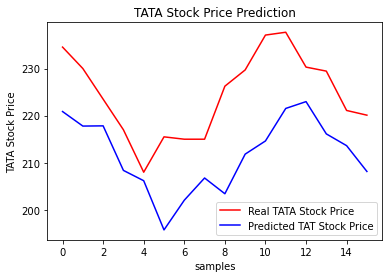

In [25]:
# 预测与实际差异的可视化
plt.plot(real_stock_price, color = 'red', label = 'Real TATA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TAT Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('samples')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()